In [1]:
%matplotlib inline
import data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
idd, seq = data.readseq('train.csv')

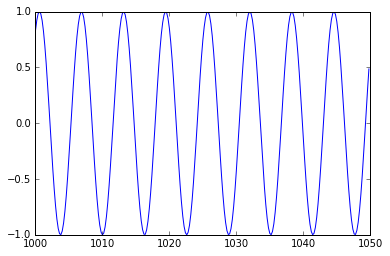

In [22]:
x = np.arange(1000, 1050, step=0.2)
y = np.sin(x)
plt.plot(x, y)
plt.show()

In [23]:
def get_batch(s, ix):
    t = s[ix]
    return t[:-1], t[1:]
def sine_data(ix,size=50):
    x = np.arange(ix, ix + size, step = 0.2)
    y = np.sin(x)
    return y[:-1], y[1:]

In [24]:
inp_out_size = 1
hidden_layer_size = 5
lr = 0.001
epoch = 7000
print_step = 200
num_steps = 15

In [25]:
# zoneout as in https://arxiv.org/pdf/1606.01305v1.pdf
def zoneout(h, h_prev):
    assert h.get_shape() == h_prev.get_shape()
    r = tf.select(tf.random_uniform(h.get_shape()) > keep, tf.ones_like(h), tf.zeros_like(h))
    h_z = tf.mul(r, h_prev) + tf.mul(tf.sub(tf.ones_like(r), r), h)
    return h_z

In [26]:
tf.reset_default_graph()
Wxh = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], maxval=0.01, minval=-0.01), dtype=tf.float32)
Whh = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Why = tf.Variable(tf.random_uniform([hidden_layer_size, inp_out_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
# weights associated with update gate
Wxz = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Whz = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
# weights associated with the reset gate
Wxr = tf.Variable(tf.random_uniform([inp_out_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)
Whr = tf.Variable(tf.random_uniform([hidden_layer_size, hidden_layer_size], minval=-0.01, maxval=0.01), dtype=tf.float32)

In [27]:
def GRU(prev, inp):
    i = tf.reshape(inp, shape=[1, -1])
    p = tf.reshape(prev, shape=[1, -1])
    z = tf.nn.sigmoid(tf.matmul(i, Wxz) + tf.matmul(p, Whz))    # update gate
    r = tf.nn.sigmoid(tf.matmul(i, Wxr) + tf.matmul(p, Whr))    # reset gate
    h_ = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(tf.mul(p, r), Whh))
#     h = tf.nn.tanh(tf.matmul(i, Wxh) + tf.matmul(p, Whh))
    h = tf.mul(tf.sub(tf.ones_like(z), z), h_) + tf.mul(z, p)
    h = zoneout(h, p)
    return tf.reshape(h, [hidden_layer_size])

In [28]:
# model
inputs = tf.placeholder(shape=[None, 1], dtype=tf.float32)
targets = tf.placeholder(shape=[None, 1], dtype=tf.float32)
keep = tf.placeholder(dtype=tf.float32)
initial = tf.placeholder(shape=[hidden_layer_size], dtype=tf.float32)
hiddens = tf.scan(GRU, inputs, initializer=initial)
outputs = tf.matmul(hiddens, Why)
loss = tf.sqrt(tf.reduce_sum(tf.square(tf.sub(outputs, targets))))
optimizer = tf.train.GradientDescentOptimizer(lr)
# grad = optimizer.compute_gradients(loss, [Wxh])[0][0]
optimize_op = optimizer.minimize(loss)

In [29]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [30]:
ix = 0
ini = np.zeros([hidden_layer_size])

In [31]:
for i in range(epoch):
    a, b = sine_data(ix, size=num_steps)    
    a = np.reshape(a, [-1, 1])
    b = np.reshape(b, [-1, 1])
    l, h, _ = sess.run([loss, hiddens, optimize_op], {inputs: a, targets: b, initial: ini, keep: 0.7})
    ix += 1
    if i % print_step == 0:
        print('Loss', l)
    ix += num_steps
    ini = h[-1]

Loss 6.20533
Loss 5.91597
Loss 6.20781
Loss 5.87345
Loss 5.39247
Loss 3.98066
Loss 2.97805
Loss 3.18435
Loss 2.98566
Loss 3.13096
Loss 2.8307
Loss 2.40622
Loss 2.48717
Loss 2.337
Loss 2.01476
Loss 2.00178
Loss 2.14632
Loss 1.99313
Loss 1.32659
Loss 1.03605
Loss 0.824245
Loss 0.875544
Loss 0.510736
Loss 0.69662
Loss 0.870592
Loss 0.65936
Loss 0.742821
Loss 1.30203
Loss 0.900248
Loss 0.827777
Loss 0.879863
Loss 1.31485
Loss 0.674541
Loss 0.733467
Loss 0.700649


In [32]:
def generate(sess, n):
    ix = [[0.2]]
    v = []
    h = np.zeros(hidden_layer_size)
    for i in range(n):
        o, h = sess.run([outputs, hiddens], {inputs:ix, initial: h, keep: 1.0})
        h = h.reshape(hidden_layer_size)
        ix = o
        v.append(np.squeeze(o))
    return v

(224,) (250,)


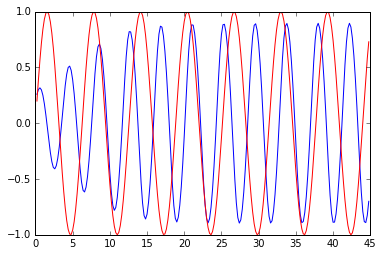

In [33]:
x = np.arange(0.2, 45, step = 0.2)
pred = np.array(generate(sess, len(x)))
true = np.sin(x)
print(x.shape, y.shape)
plt.plot(x, pred, 'b-')
plt.plot(x, true, 'r-')
plt.show()